# Data Visualisation

## Visualisation of the three viewing angles according to the sign

view_angle,Back,Front,Side
sign_type,,,
Blind-Spot Mirror (Convex),10,11,11
No Entry (One Way),21,24,27
No Through Road (T-Sign),4,3,3
Pedestrian Crossing,8,8,9
Roundabout Ahead,7,8,7
Stop,11,11,11


view_angle
Side     68
Front    65
Back     61
Name: count, dtype: int64


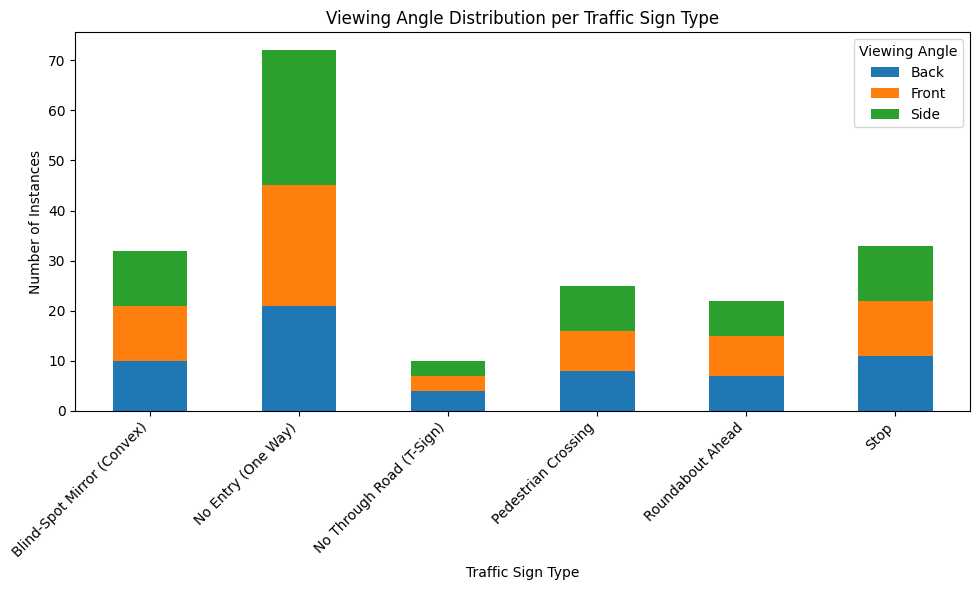

In [ ]:
# Imports
import json
import pandas as pd
import matplotlib.pyplot as plt


# Load Label Studio annotations 
def load_labelstudio_annotations(json_path):
    """
    Loads Label Studio annotations and extracts:
    - sign_type (rectangle label)
    - view_angle (per-region choice)

    Returns:
        pd.DataFrame with columns:
        ['sign_type', 'view_angle']
    """
    records = []

    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    for task in data:
        for ann in task.get("annotations", []):

            # Group annotation results by region ID
            regions = {}

            for r in ann.get("result", []):
                region_id = r.get("id")
                if region_id not in regions:
                    regions[region_id] = {}
                regions[region_id][r["from_name"]] = r["value"]

            # Extract attributes per traffic sign
            for region in regions.values():
                if "sign_type" in region and "view_angle" in region:
                    records.append({
                        "sign_type": region["sign_type"]["rectanglelabels"][0],
                        "view_angle": region["view_angle"]["choices"][0],
                    })

    return pd.DataFrame(records)


# Load annotations
df = load_labelstudio_annotations("json_stefania.json")

# Inspect data
# Load annotations
df = load_labelstudio_annotations("json_stefania.json")

# Summary table: Sign Type vs Viewing Angle
summary_table = (
    df.groupby(["sign_type", "view_angle"])
      .size()
      .unstack(fill_value=0)
)

display(summary_table)
print(df["view_angle"].value_counts())


# Visualisation:
# Sign Type vs Viewing Angle
counts = (
    df.groupby(["sign_type", "view_angle"])
      .size()
      .unstack(fill_value=0)
)

counts.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6)
)

plt.title("Viewing Angle Distribution per Traffic Sign Type")
plt.xlabel("Traffic Sign Type")
plt.ylabel("Number of Instances")
plt.legend(title="Viewing Angle")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Note how some of the signs do not have equal front, back and side views. This is due to the fact that there are images which had some background signs which we decided to label as well, to have a higher reliable model that can be used as a good prototype.

## Splitting the dataset into train and test sets

In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_dataset(images_dir, output_dir, train_ratio=0.8, seed=42):

    image_files = []

    # Walk through Label Studio upload structure
    for root, _, files in os.walk(images_dir):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                image_files.append(os.path.join(root, file))

    # Train / test split using sklearn
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    train_images, test_images = train_test_split(
        image_files,
        train_size=train_ratio,
        random_state=seed,
        shuffle=True
    )

    # Copy files
    for split, split_images in {
        "train": train_images,
        "test": test_images
    }.items():
        out_dir = os.path.join(output_dir, split, "images")
        os.makedirs(out_dir, exist_ok=True)

        for src_path in split_images:
            filename = os.path.basename(src_path)
            dst_path = os.path.join(out_dir, filename)
            shutil.copy(src_path, dst_path)

    print(f"Saved train/test split to: {output_dir}")

In [2]:
split_dataset(
    images_dir="label-studio/label-studio/media/upload/2",
    output_dir="data_split/",
    train_ratio=0.8,
)

Saved train/test split to: data_split/
